In [ ]:
#!pip install vaderSentiment

In [ ]:
import json
import requests
import re
import os
from keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
from datetime import datetime
from gensim.parsing.preprocessing import remove_stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from keras import regularizers
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import spacy
from sklearn.model_selection import cross_validate
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import BernoulliRBM
from sklearn.ensemble import StackingClassifier
from hyperopt import hp
import warnings
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, LSTM, SimpleRNN
from keras.layers import MaxPooling1D, Conv1D, Embedding, Masking, Reshape
from keras.utils import np_utils, normalize
warnings.filterwarnings("ignore")
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
analyser = SentimentIntensityAnalyzer()
from numpy.random import seed
seed(1)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Extraction/Cleaning

In [ ]:
def clean_text(x, label = ''):
    try:
        x = re.sub(r"<[^>]+>", "", x)
        x = re.sub(r"\bgt\b", "", x)
        x = re.sub(r"[^A-Za-z(),!?\'\`]", " ", x)
        x = re.sub(r"\'s", " \'s", x)
        x = re.sub(r"\'ve", " \'ve", x)
        x = re.sub(r"n\'t", " n\'t", x)
        x = re.sub(r"\'re", " \'re", x)
        x = re.sub(r"\'d", " \'d", x)
        x = re.sub(r"\'ll", " \'ll", x)
        x = re.sub(r",", " ", x)
        x = re.sub(r"!", " ", x)
        x = re.sub(r"\(", "", x)
        x = re.sub(r"\)", "", x)
        x = re.sub(r"\?", "", x)
        x = re.sub(r"/", "", x)
        x = re.sub(r"\s{2,}", " ", x)
        x = re.sub(r"\b"+label+"\b", "", x)
        return x.lower()
    except:
        return ''

The "clean_test" function performs regex cleaning of the text, it removes punctuations and converts the text to lower case.

In [ ]:
def get_data(label):
    if label+'.json' not in os.listdir():
        url = 'https://a.4cdn.org/'+label+'/catalog.json'
        r = requests.get(url, allow_redirects=True)
        open(label+'.json', 'wb').write(r.content)

    out = json.load(open(label+'.json',))
    texts = []
    times = []
    num_replies = []
    replies = []
    for i in range(len(out)):
        for j in range(len(out[i]['threads'])):
            obj = out[i]['threads'][j]
            if 'com' in obj.keys():
                com = obj['com']
                texts.append(clean_text(com, label))
            times.append(datetime.utcfromtimestamp(obj['time']).strftime('%Y-%m-%d %H:%M:%S'))
            num_replies.append(obj['replies'])
            if 'last_replies' in obj.keys():
                obj_reply = obj['last_replies']
                replies.append(''.join(list(map(lambda x: clean_text(obj_reply[x]['com'], label) if 'com' in obj_reply[x].keys() else '', range(len(obj_reply))))))
            else:
                replies.append('')

    return zip(texts, times, num_replies, replies, map(lambda x: label, range(len(texts))))

The "get_data" function gets data from 4chan and puts it in a dataframe containing post text, last replies, number of replies, time of posting and the channel in which the post was found.

In [ ]:
%%time
df = pd.concat([pd.DataFrame(list(get_data('g')), columns = ['text', 'time', 'num_replies', 'last_replies', 'label']),
                pd.DataFrame(list(get_data('tv')), columns = ['text', 'time', 'num_replies', 'last_replies', 'label']),
                pd.DataFrame(list(get_data('ck')), columns = ['text', 'time', 'num_replies', 'last_replies', 'label']),
                pd.DataFrame(list(get_data('lit')), columns = ['text', 'time', 'num_replies', 'last_replies', 'label'])])
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by = 'time', ascending = True)
df = df.reset_index(drop = True)

CPU times: user 230 ms, sys: 12 ms, total: 242 ms
Wall time: 1.52 s


This creates the dataframe calling the "get_data" function and sorts it by time.

In [ ]:
df['label'] = df['label'].map({'g':'Technology', 'tv': 'TV & Film', 'ck': 'Food & Cooking', 'lit': 'Literature'})

I'm changing the channels from their codes in the website to a human understandable form to make it easier for further processing.

In [ ]:
df.head()

text  ...           label
0  the g wiki http wiki installgentoo com g is fo...  ...      Technology
1   lit is for the discussion of literature speci...  ...      Literature
2                               post menus here boys  ...  Food & Cooking
3  whats your favorite tea recently bought some d...  ...  Food & Cooking
4  r my authentic poutine delivery from belle pro...  ...  Food & Cooking

[5 rows x 5 columns]

In [ ]:
%%time
df['text'] = df['text'].apply(remove_stopwords)
df['last_replies'] = df['last_replies'].apply(remove_stopwords)

CPU times: user 19.9 ms, sys: 0 ns, total: 19.9 ms
Wall time: 20.2 ms


I'm removing stopwords from both the text of the posts and their replies as these words would be present in large numbers in the data and wouldn't add value to the analysis.

In [ ]:
def lemmatizer(x):
    return ' '.join([token.lemma_ for token in nlp(x)])

In [ ]:
%%time
df['text'] = df['text'].apply(lemmatizer)
df['last_replies'] = df['last_replies'].apply(lemmatizer)

CPU times: user 6.28 s, sys: 25.6 ms, total: 6.31 s
Wall time: 6.36 s


I'm lemmatizing the text of the post and the replies to get redundancy in the data.

In [ ]:
df.head()

text  ...           label
0  g wiki http wiki installgentoo com g discussio...  ...      Technology
1  lit discussion literature specifically book fi...  ...      Literature
2                                     post menus boy  ...  Food & Cooking
3  what s favorite tea recently buy darjeele pic ...  ...  Food & Cooking
4  r authentic poutine delivery belle province mo...  ...  Food & Cooking

[5 rows x 5 columns]

# Exploratory Analysis

## Word Clouds for the 100 most common words in the data
I'm plotting word clouds for the most common words in the data. This would characterize the kind of text in the data and help us look at if certain words are used more often in one channel than the other.

### For the entire dataset

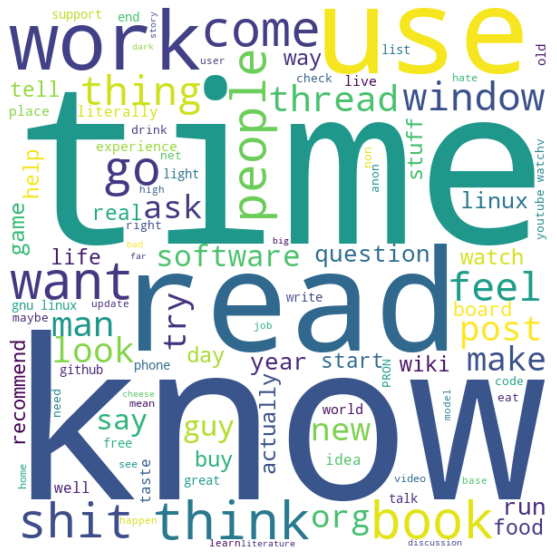

In [ ]:
stopwords = list(STOPWORDS) + ['https', 'will', 'amp', 'add', 'fucking', 've', 'isn', 'quot', 'fuck', 'good']
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['text']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The figure above shows the 100 most common words for the text of the posts across all channels. The size of the word in the word cloud is propostional to the frequency of its occurence in the data. Words like time, read, know, work, use are the most common words from the word cloud.

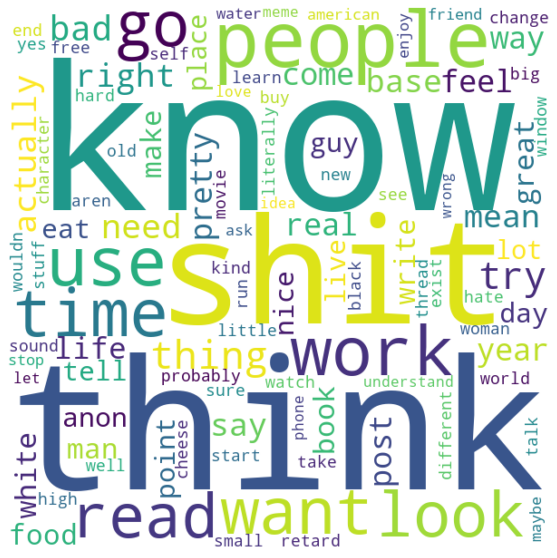

In [ ]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['last_replies']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The figure above shows the 100 most common words for the text of the replies for the posts across all channels. The size of the word in the word cloud is propostional to the frequency of its occurence in the data. Words like think, shit, know, people, work are the most common words from the word cloud.

### For Technology

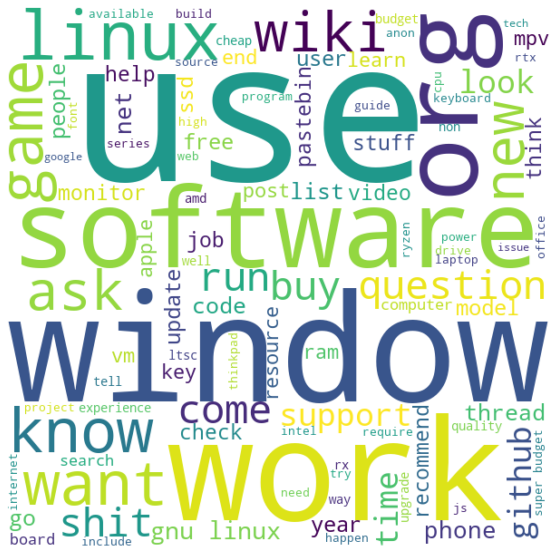

In [ ]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['text'][df['label'] == 'Technology']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The figure above shows the 100 most common words for the text of the posts in technology. The size of the word in the word cloud is propostional to the frequency of its occurence in the data. Words like window, work, software, use, wiki, linux are the most common words from the word cloud.

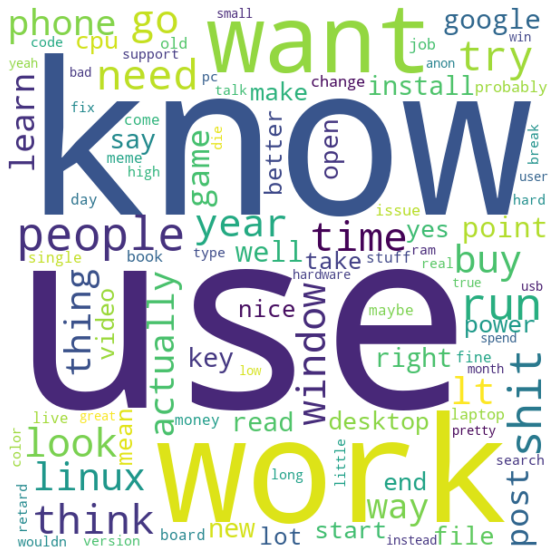

In [ ]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['last_replies'][df['label'] == 'Technology']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The figure above shows the 100 most common words for the text of the replies for the posts in techology. The size of the word in the word cloud is propostional to the frequency of its occurence in the data. Words like use, work, know, want are the most common words from the word cloud.

### For TV & Film

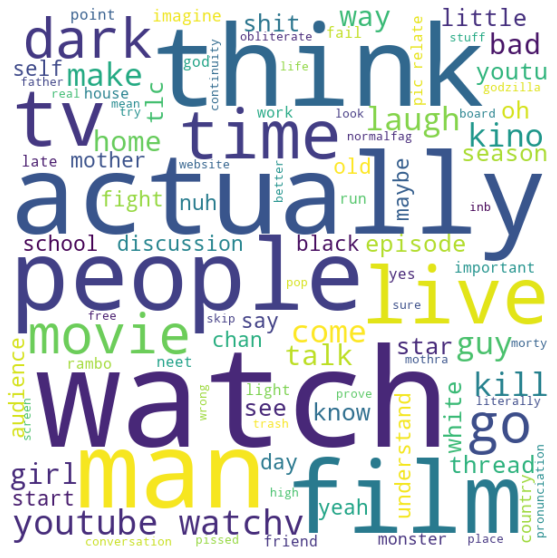

In [ ]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['text'][df['label'] == 'TV & Film']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The figure above shows the 100 most common words for the text of the posts in TV & Film. The size of the word in the word cloud is propostional to the frequency of its occurence in the data. Words like watch, film, movie, think are the most common words from the word cloud.

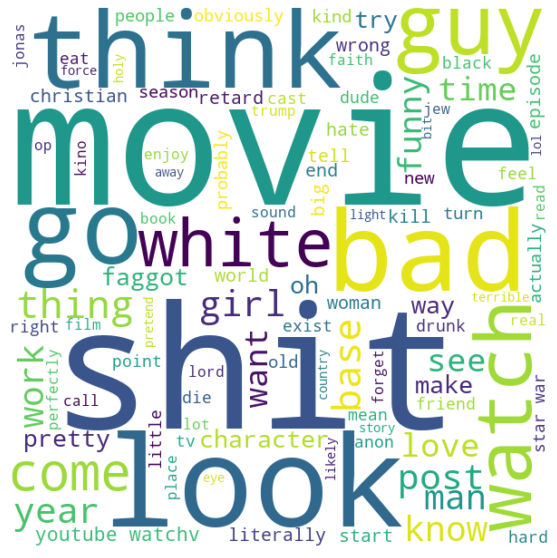

In [ ]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['last_replies'][df['label'] == 'TV & Film']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The figure above shows the 100 most common words for the text of the replies for the posts in TV & Film. The size of the word in the word cloud is propostional to the frequency of its occurence in the data. Words like look, movie, think, shit, white are the most common words from the word cloud.

### For Food & Cooking

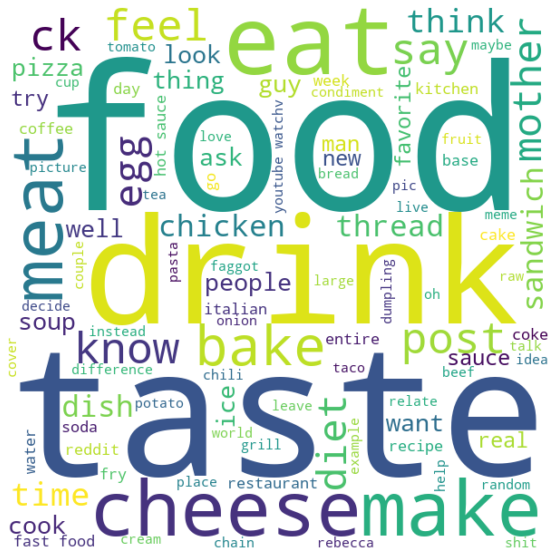

In [ ]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['text'][df['label'] == 'Food & Cooking']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The figure above shows the 100 most common words for the text of the posts in Food & Cooking. The size of the word in the word cloud is propostional to the frequency of its occurence in the data. Words like food, drink, taste, cheese, make are the most common words from the word cloud.

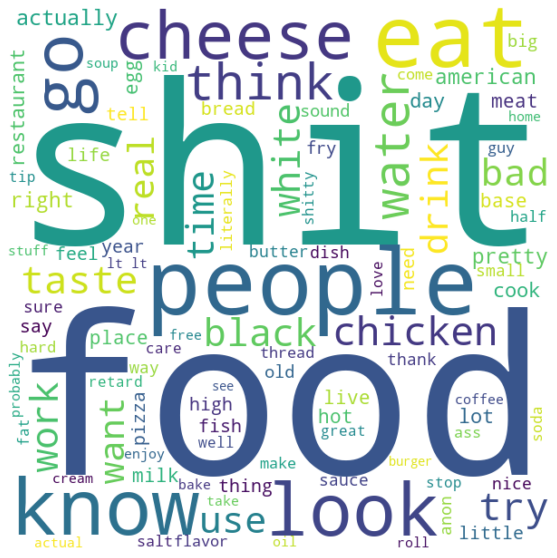

In [ ]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['last_replies'][df['label'] == 'Food & Cooking']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The figure above shows the 100 most common words for the text of the replies for the posts in Food & Cooking. The size of the word in the word cloud is propostional to the frequency of its occurence in the data. Words like food, people, shit, chicken, cheese are the most common words from the word cloud.

### For Literature

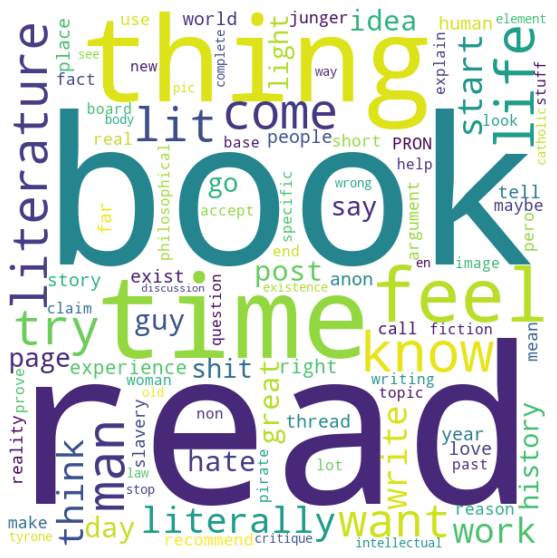

In [ ]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['text'][df['label'] == 'Literature']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The figure above shows the 100 most common words for the text of the posts in Literature. The size of the word in the word cloud is propostional to the frequency of its occurence in the data. Words like read, time, book, thing, feel are the most common words from the word cloud.

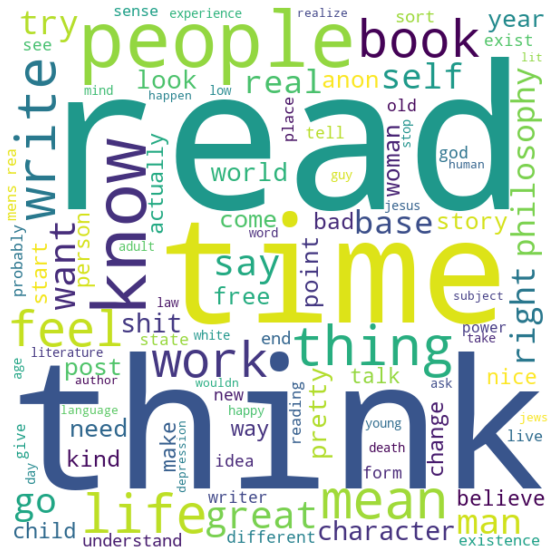

In [ ]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(df['last_replies'][df['label'] == 'Literature']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The figure above shows the 100 most common words for the text of the replies for the posts in Literature. The size of the word in the word cloud is propostional to the frequency of its occurence in the data. Words like think, read, time, people, book are the most common words from the word cloud.

## Number of Replies 
The number of replies a post gets can be considered as an indicator of the level of engagement that the post has. Thus, looking at the distibution of the number of replies is important. 

### Histogram of Number of Replies

#### For the entrie dataset

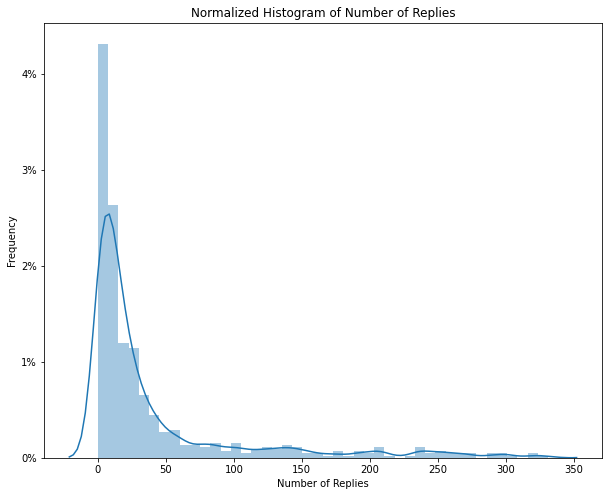

In [ ]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sns.distplot(df['num_replies'], ax = ax)
vals = ax.get_yticks()
vals = [str(int(x*100))+'%' for x in vals]
ax.set_yticklabels(vals)
plt.title("Normalized Histogram of Number of Replies")
plt.ylabel('Frequency')
plt.xlabel('Number of Replies')
plt.show()

#### For Technology

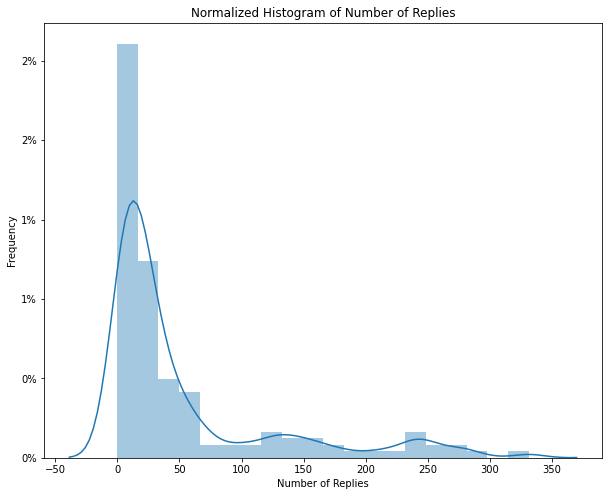

In [ ]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sns.distplot(df['num_replies'][df['label'] == 'Technology'], ax = ax)
vals = ax.get_yticks()
vals = [str(int(x*100))+'%' for x in vals]
ax.set_yticklabels(vals)
plt.title("Normalized Histogram of Number of Replies")
plt.ylabel('Frequency')
plt.xlabel('Number of Replies')
plt.show()

#### For TV & Film

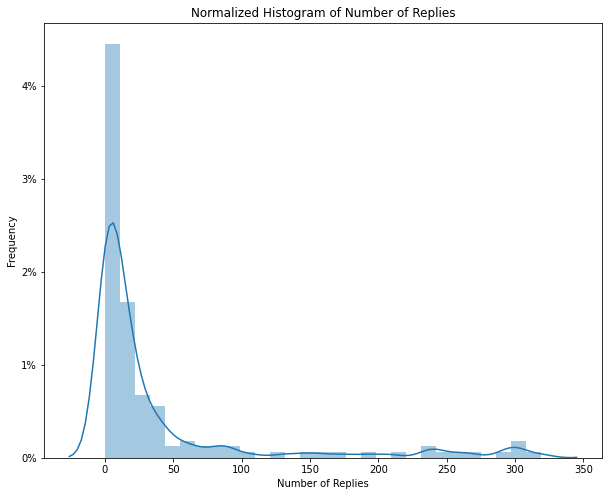

In [ ]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sns.distplot(df['num_replies'][df['label'] == 'TV & Film'], ax = ax)
vals = ax.get_yticks()
vals = [str(int(x*100))+'%' for x in vals]
ax.set_yticklabels(vals)
plt.title("Normalized Histogram of Number of Replies")
plt.ylabel('Frequency')
plt.xlabel('Number of Replies')
plt.show()

#### For Food & Cooking

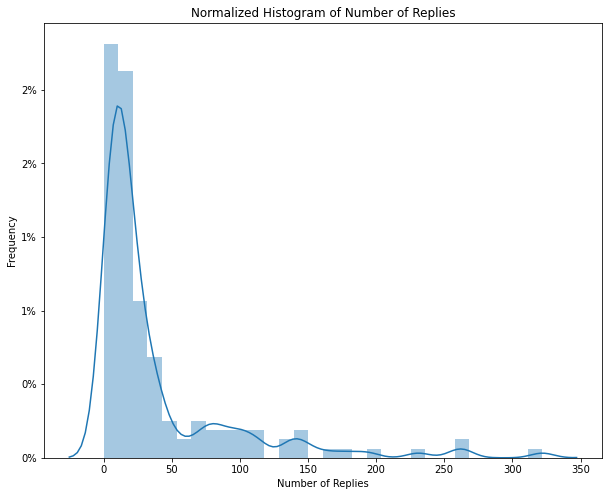

In [ ]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sns.distplot(df['num_replies'][df['label'] == 'Food & Cooking'], ax = ax)
vals = ax.get_yticks()
vals = [str(int(x*100))+'%' for x in vals]
ax.set_yticklabels(vals)
plt.title("Normalized Histogram of Number of Replies")
plt.ylabel('Frequency')
plt.xlabel('Number of Replies')
plt.show()

#### For Literature

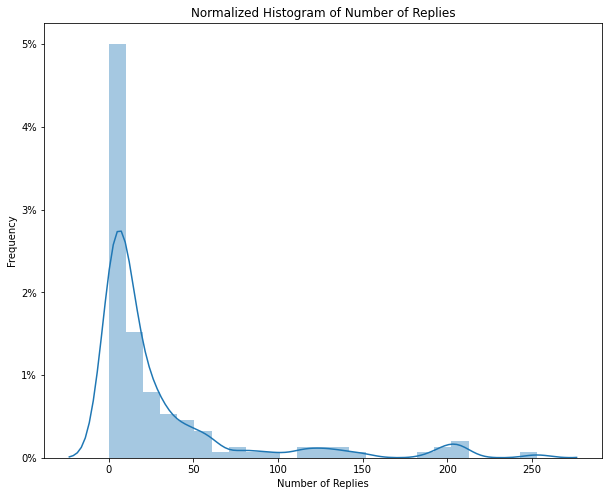

In [ ]:
plt.figure(figsize=(10,8))
ax = plt.gca()
sns.distplot(df['num_replies'][df['label'] == 'Literature'], ax = ax)
vals = ax.get_yticks()
vals = [str(int(x*100))+'%' for x in vals]
ax.set_yticklabels(vals)
plt.title("Normalized Histogram of Number of Replies")
plt.ylabel('Frequency')
plt.xlabel('Number of Replies')
plt.show()

It can be obeserved that the mean number of replies that posts get are approximately the same across all channels and most posts in the website don't get replies. However, it can be seen from the graphs that the distributions are slightly different for some channels.

### Boxplot for the Number of Replies for different Channels

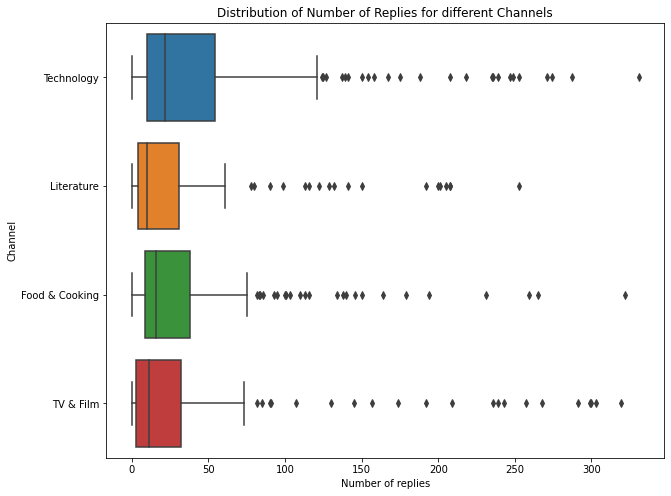

In [ ]:
plt.figure(figsize=(10,8))
ax = plt.gca()
f = sns.boxplot(x="num_replies", y="label", data=df, ax=ax)
plt.ylabel("Channel")
plt.xlabel("Number of replies")
plt.title("Distribution of Number of Replies for different Channels")
plt.show()

It can be obeserved that while the mean are very close to each other, Technology on average has the highest number of replies. The range of the number of replies for technology is also much more spread out, indicating that some posts in technology get a significantly more replies than the average post across channels. 

## Sentiment Analysis
Analysis of the sentiment of the posts can give key insights regarding what is viewed positively in the data and what isn't. We can also examine the if the channel of the post is correlated to the sentiment behind it.

### Sentiment of the Posts
This section analysis the sentiments of the posts.

In [ ]:
%%time
df['text_neg'] = df['text'].apply(lambda x: analyser.polarity_scores(x)['neg'])
df['text_neu'] = df['text'].apply(lambda x: analyser.polarity_scores(x)['neu'])
df['text_pos'] = df['text'].apply(lambda x: analyser.polarity_scores(x)['pos'])

CPU times: user 369 ms, sys: 1.07 ms, total: 370 ms
Wall time: 371 ms


#### Postive Sentiments

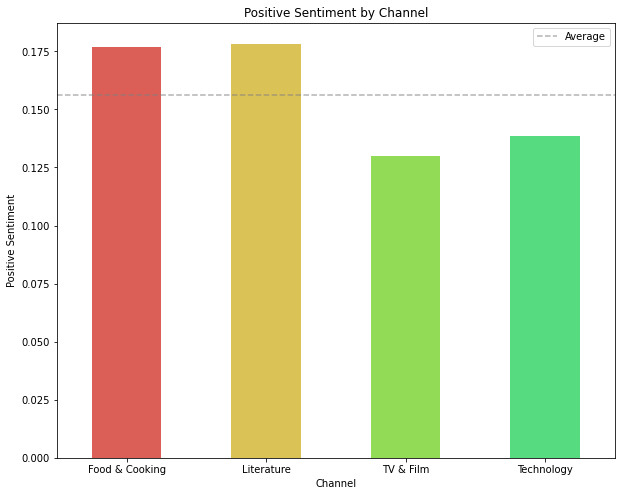

In [ ]:
plt.figure(figsize = (10,8))
ax = plt.gca()
df.groupby('label')['text_pos'].mean().plot(kind = 'bar', ax = ax, rot = 0, color = sns.color_palette("hls", 8))
plt.axhline(y = df['text_pos'].mean(), linestyle = '--', color = 'grey', alpha = 0.6, label = 'Average')
plt.xlabel('Channel')
plt.ylabel("Positive Sentiment")
plt.title('Positive Sentiment by Channel')
plt.legend(['Average'])
plt.show()

The bar chart above shows the distribution of positive sentiment across the channels. It can be observed from the graph that Food & Cooking and Literature received a much higher positive sentiment than the average for the data.

#### Neutral Sentiments

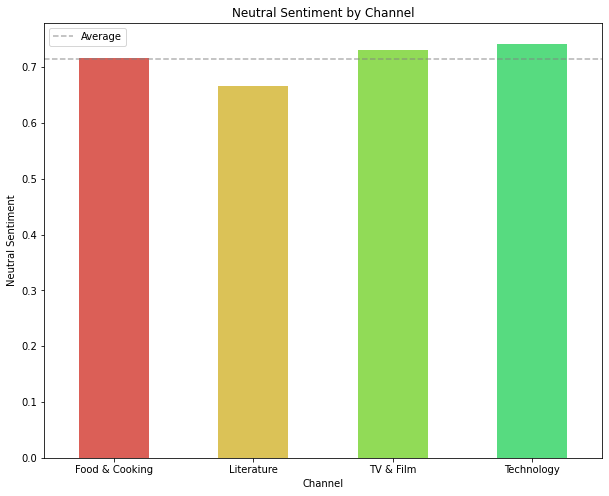

In [ ]:
plt.figure(figsize = (10,8))
ax = plt.gca()
df.groupby('label')['text_neu'].mean().plot(kind = 'bar', ax = ax, rot = 0, color = sns.color_palette("hls", 8))
plt.axhline(y = df['text_neu'].mean(), linestyle = '--', color = 'grey', alpha = 0.6, label = 'Average')
plt.xlabel('Channel')
plt.ylabel("Neutral Sentiment")
plt.title('Neutral Sentiment by Channel')
plt.legend(['Average'])
plt.show()

The bar chart above shows the distribution of neutral sentiment across the channels. It can be observed from the graph that Technology and TV & Film received a more neutral sentiment than the average for the data. It could mean that posts in those channels are more objective.

#### Negative Sentiments

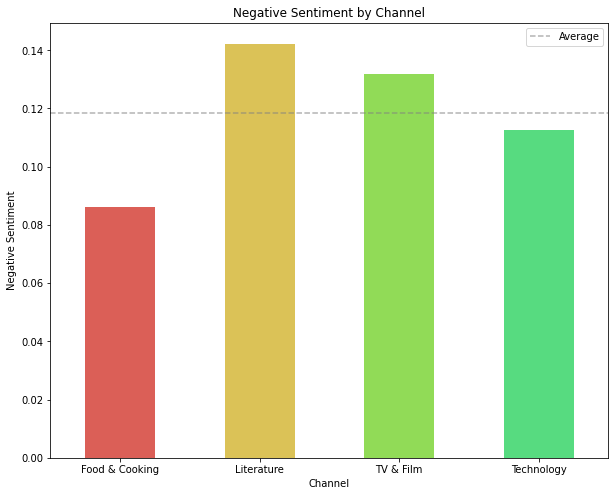

In [ ]:
plt.figure(figsize = (10,8))
ax = plt.gca()
df.groupby('label')['text_neg'].mean().plot(kind = 'bar', ax = ax, rot = 0, color = sns.color_palette("hls", 8))
plt.axhline(y = df['text_neg'].mean(), linestyle = '--', color = 'grey', alpha = 0.6, label = 'Average')
plt.xlabel('Channel')
plt.ylabel("Negative Sentiment")
plt.title('Negative Sentiment by Channel')
plt.legend(['Average'])
plt.show()

The bar chart above shows the distribution of negative sentiment across the channels. It can be observed from the graph that TV & Film and Literature received a much higher negative sentiment than the average for the data, whereas Food & Cooking received a much lower negative sentiment compared to the average.

### Sentiment of Replies
Analysis of the sentiment of the replies to the posts is just as important or even more important the analysing the sentiment of the posts as this in effect examines the reactions to the post.

In [ ]:
%%time
df['last_replies_neg'] = df['last_replies'].apply(lambda x: analyser.polarity_scores(x)['neg'])
df['last_replies_neu'] = df['last_replies'].apply(lambda x: analyser.polarity_scores(x)['neu'])
df['last_replies_pos'] = df['last_replies'].apply(lambda x: analyser.polarity_scores(x)['pos'])

CPU times: user 1.19 s, sys: 1.01 ms, total: 1.19 s
Wall time: 1.19 s


#### Positive Sentiments

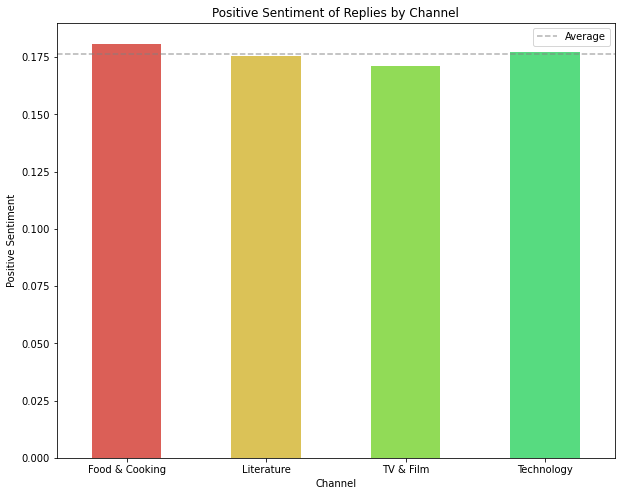

In [ ]:
plt.figure(figsize = (10,8))
ax = plt.gca()
df.groupby('label')['last_replies_pos'].mean().plot(kind = 'bar', ax = ax, rot = 0, color = sns.color_palette("hls", 8))
plt.axhline(y = df['last_replies_pos'].mean(), linestyle = '--', color = 'grey', alpha = 0.6, label = 'Average')
plt.xlabel('Channel')
plt.ylabel("Positive Sentiment")
plt.title('Positive Sentiment of Replies by Channel')
plt.legend(['Average'])
plt.show()

The bar chart above shows the distribution of positive sentiment for replies across the channels. It can be observed from the graph that Food & Cooking received a higher positive sentiment than the average for the data.

#### Neutral Sentiment

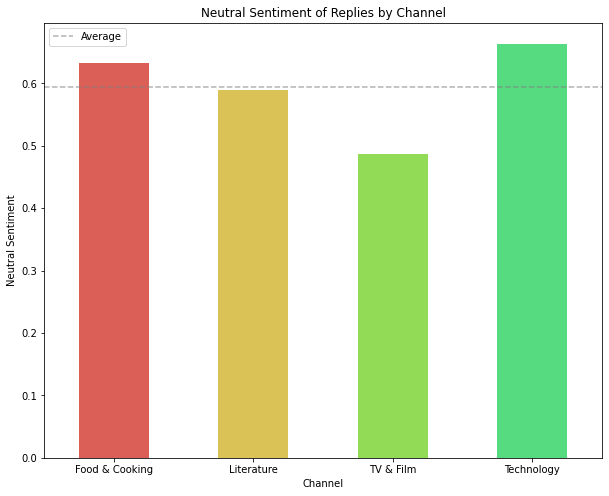

In [ ]:
plt.figure(figsize = (10,8))
ax = plt.gca()
df.groupby('label')['last_replies_neu'].mean().plot(kind = 'bar', ax = ax, rot = 0, color = sns.color_palette("hls", 8))
plt.axhline(y = df['last_replies_neu'].mean(), linestyle = '--', color = 'grey', alpha = 0.6, label = 'Average')
plt.xlabel('Channel')
plt.ylabel("Neutral Sentiment")
plt.title('Neutral Sentiment of Replies by Channel')
plt.legend(['Average'])
plt.show()

The bar chart above shows the distribution of neutral sentiment for replies across the channels. It can be observed from the graph that Technology and Food & Cooking received a more neutral sentiment than the average for the data. It could mean that posts in those channels are more objective.

####  Negative Sentiments 

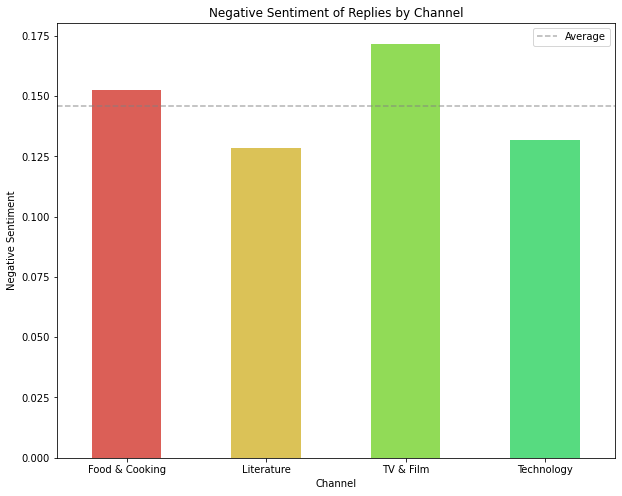

In [ ]:
plt.figure(figsize = (10,8))
ax = plt.gca()
df.groupby('label')['last_replies_neg'].mean().plot(kind = 'bar', ax = ax, rot = 0, color = sns.color_palette("hls", 8))
plt.axhline(y = df['last_replies_neg'].mean(), linestyle = '--', color = 'grey', alpha = 0.6, label = 'Average')
plt.xlabel('Channel')
plt.ylabel("Negative Sentiment")
plt.title('Negative Sentiment of Replies by Channel')
plt.legend(['Average'])
plt.show()

The bar chart above shows the distribution of negative sentiment for the replies across the channels. It can be observed from the graph that TV & Film and Food & Cooking received a much higher negative sentiment than the average for the data, whereas Literture and Techology received a much lower negative sentiment compared to the average. 

## Most common words based on polarity
This section looks are the most common words based on the polarity of the posts and replies.


### For the entire dataset

#### Most common words for posts in the top 25% ranked by positive sentiment

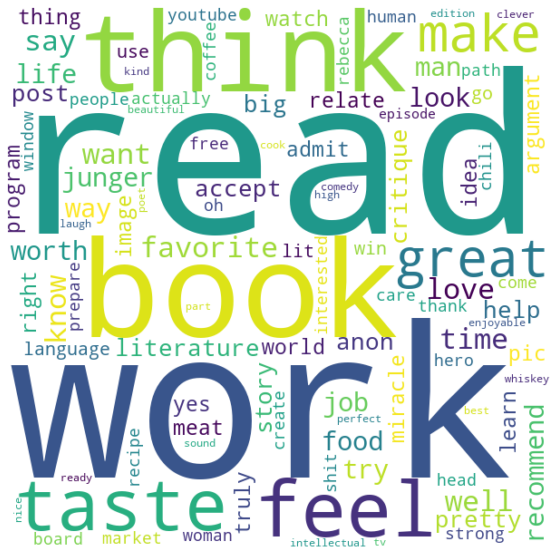

In [ ]:
text = df.sort_values(by = 'text_pos', ascending = False).head(int(df.shape[0]*0.25))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(text['text']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Most common words for posts in the top 25% ranked by negative sentiment

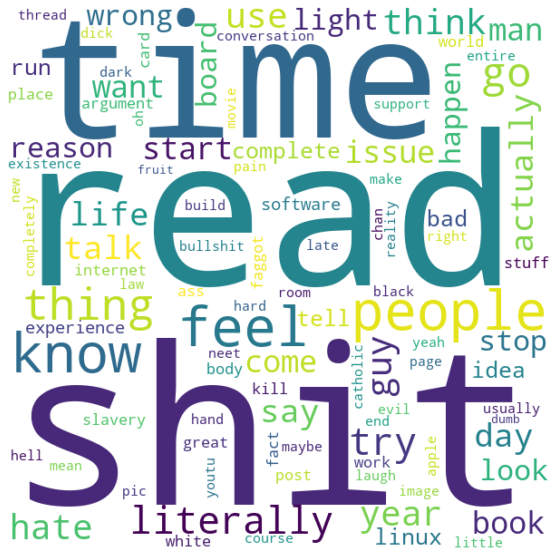

In [ ]:
text = df.sort_values(by = 'text_neg', ascending = False).head(int(df.shape[0]*0.25))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(text['text']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### For Technology


#### Most common words for posts in the top 25% ranked by positive sentiment

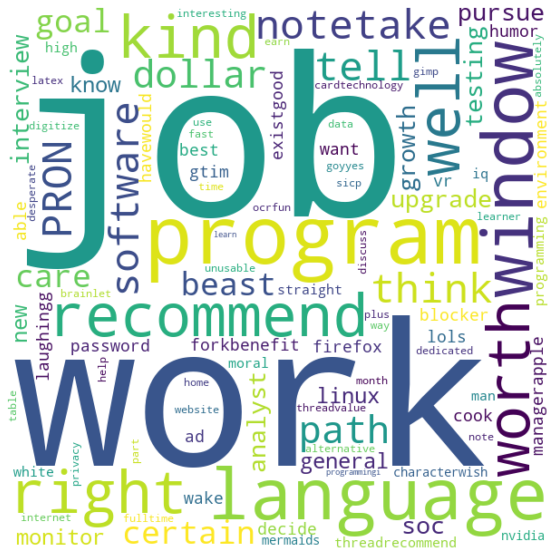

In [ ]:
text = df.sort_values(by = 'text_pos', ascending = False).head(int(df.shape[0]*0.25))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(text['text'][text['label'] == 'Technology']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Most common words for posts in the top 25% ranked by negative sentiment

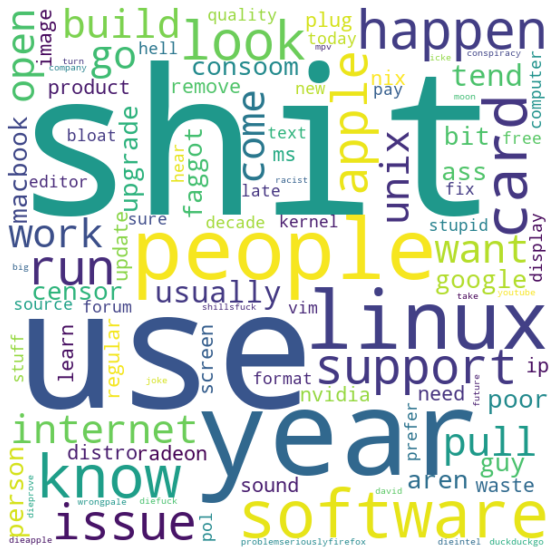

In [ ]:
text = df.sort_values(by = 'text_neg', ascending = False).head(int(df.shape[0]*0.25))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(text['text'][text['label'] == 'Technology']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### For TV & Film




#### Most common words for posts in the top 25% ranked by positive sentiment

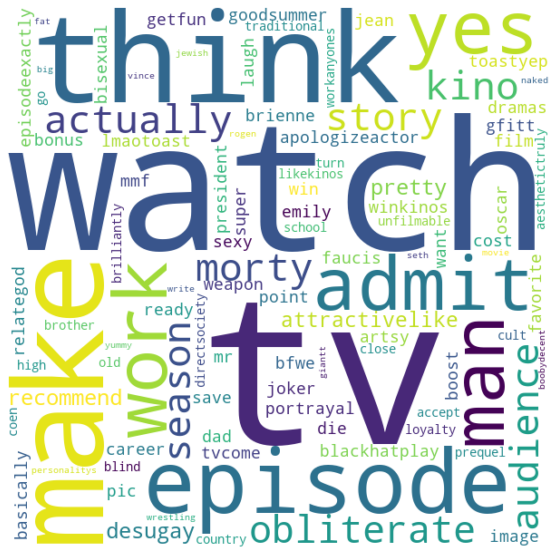

In [ ]:
text = df.sort_values(by = 'text_pos', ascending = False).head(int(df.shape[0]*0.25))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(text['text'][text['label'] == 'TV & Film']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Most common words for posts in the top 25% ranked by negative sentiment

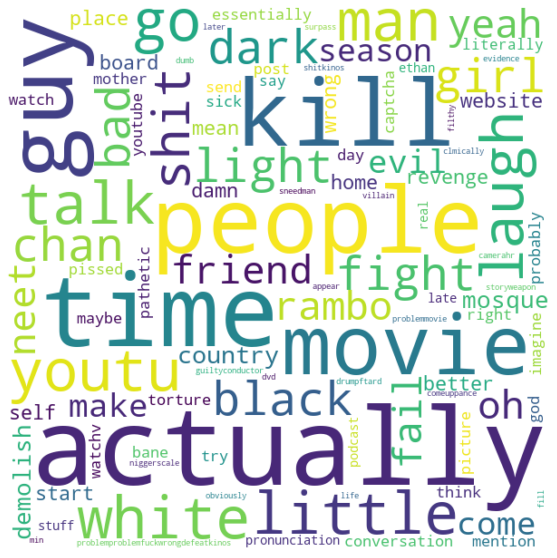

In [ ]:
text = df.sort_values(by = 'text_neg', ascending = False).head(int(df.shape[0]*0.25))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(text['text'][text['label'] == 'TV & Film']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### For Food & Cooking


#### Most common words for posts in the top 25% ranked by positive sentiment

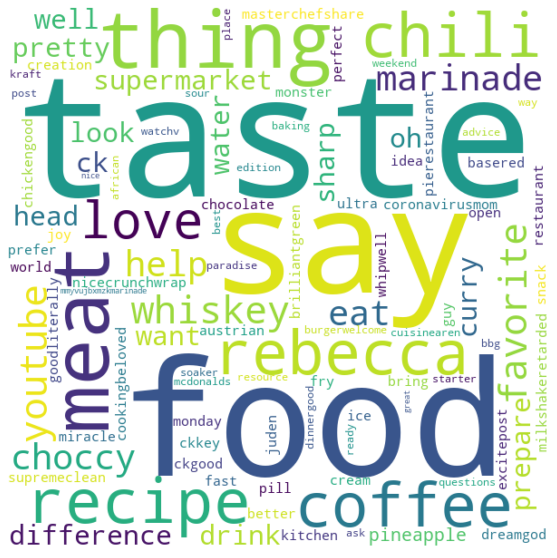

In [ ]:
text = df.sort_values(by = 'text_pos', ascending = False).head(int(df.shape[0]*0.25))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(text['text'][text['label'] == 'Food & Cooking']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Most common words for posts in the top 25% ranked by negative sentiment

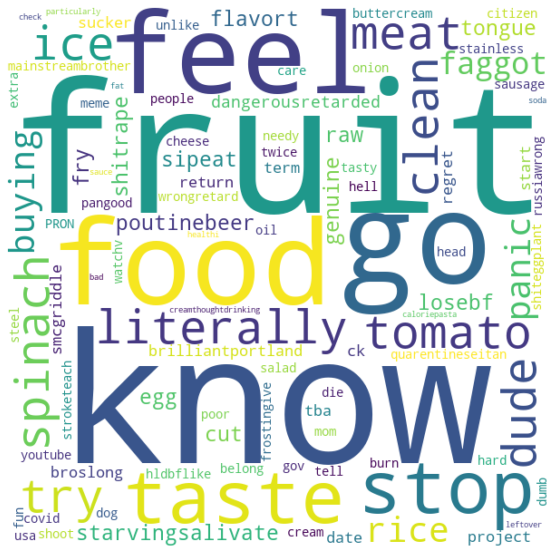

In [ ]:
text = df.sort_values(by = 'text_neg', ascending = False).head(int(df.shape[0]*0.25))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(text['text'][text['label'] == 'Food & Cooking']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### For Literature


#### Most common words for posts in the top 25% ranked by positive sentiment

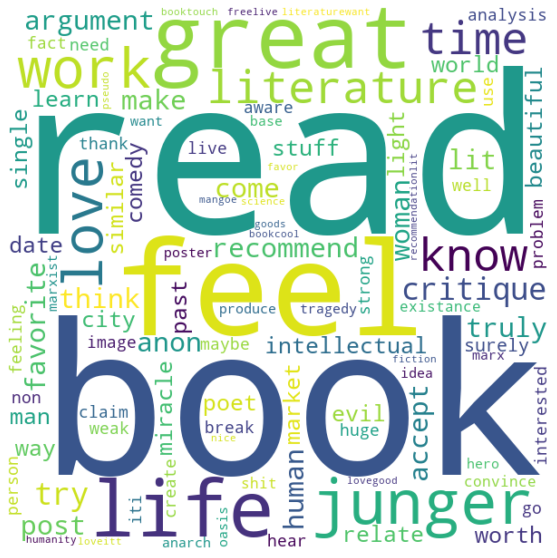

In [ ]:
text = df.sort_values(by = 'text_pos', ascending = False).head(int(df.shape[0]*0.25))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(text['text'][text['label'] == 'Literature']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Most common words for posts in the top 25% ranked by negative sentiment

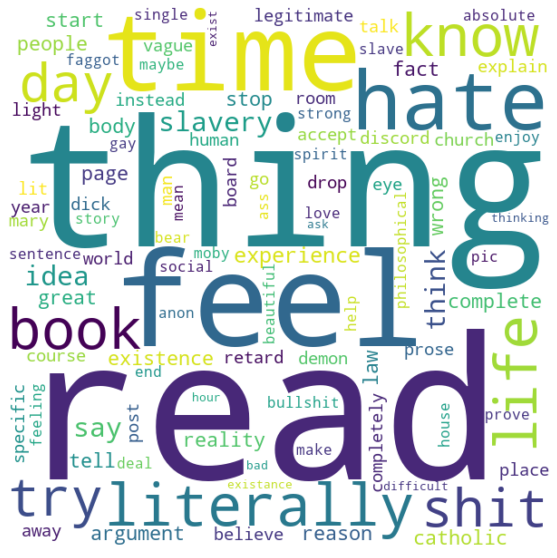

In [ ]:
text = df.sort_values(by = 'text_neg', ascending = False).head(int(df.shape[0]*0.25))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100,
                      width = 600, height = 600, random_state = 100).generate(''.join(text['text'][text['label'] == 'Literature']))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Discriminative Analysis

### Linear Discriminant Analysis
In this section explores the use of Linear Discriminant Analysis to seperate the data for different channels and looks at which field seprates it the best.

In [ ]:
tfidf = TfidfVectorizer(max_features = 500)
X_text = tfidf.fit_transform(df['text']).toarray()

y_encoder = LabelEncoder()
y = y_encoder.fit_transform(df['label'])

#### Linear Discriminant Analysis of Post text

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_text_lda = lda.fit_transform(X_text, y)

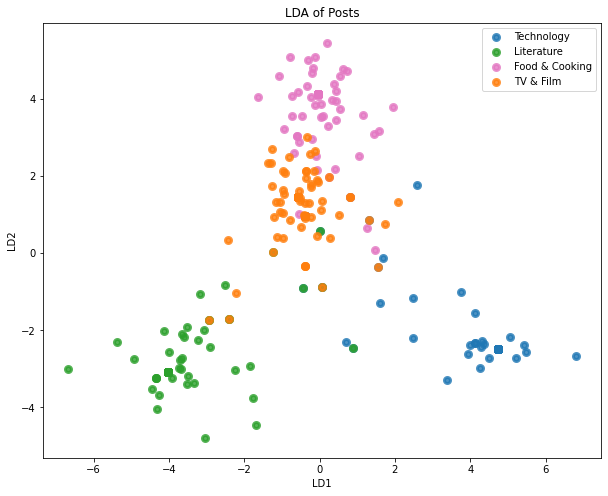

In [ ]:
plt.figure(figsize = (10, 8))
colors = ['tab:blue', 'tab:green', 'tab:pink', 'tab:orange']
lw = 3
for color,target_name in zip(colors, df['label'].unique()):
    plt.scatter(X_text_lda[df['label'] == target_name, 0], X_text_lda[df['label'] == target_name, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title('LDA of Posts')
plt.show()

#### Linear Discriminant Analysis of Post Replies text

In [ ]:
X_reply = tfidf.fit_transform(df['last_replies']).toarray()

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_reply_lda = lda.fit_transform(X_reply, y)

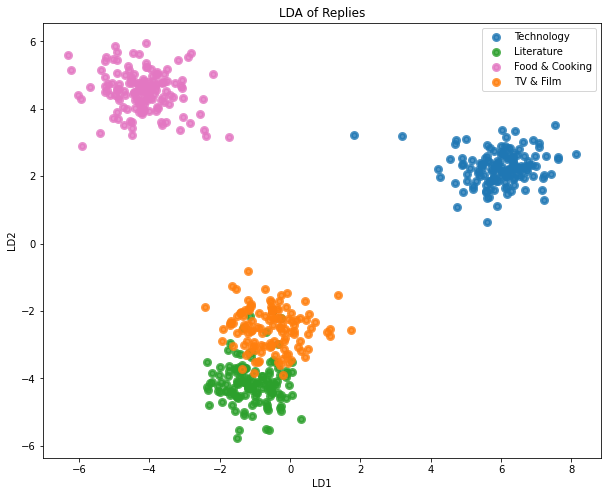

In [ ]:
plt.figure(figsize = (10, 8))
colors = ['tab:blue', 'tab:green', 'tab:pink', 'tab:orange']
lw = 3
for color,target_name in zip(colors, df['label'].unique()):
    plt.scatter(X_reply_lda[df['label'] == target_name, 0], X_reply_lda[df['label'] == target_name, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title('LDA of Replies')
plt.show()

#### Linear Discriminant Analysis of a combination of Post and Replies text

In [ ]:
X_all_text = tfidf.fit_transform(df['text'] +' ' + df['last_replies']).toarray()

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_all_text_lda = lda.fit_transform(X_all_text, y)

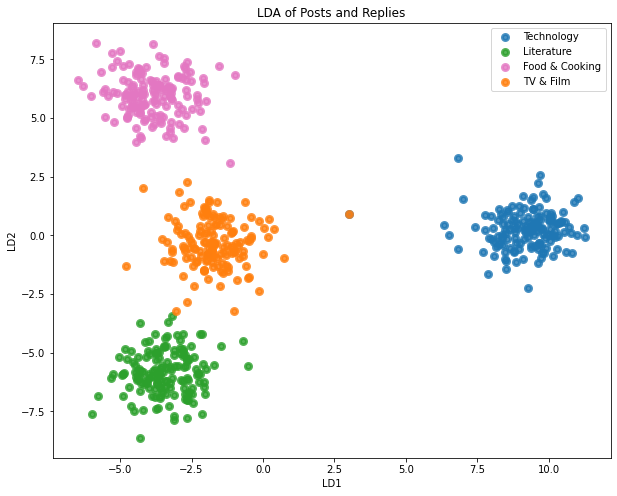

In [ ]:
plt.figure(figsize = (10, 8))
colors = ['tab:blue', 'tab:green', 'tab:pink', 'tab:orange']
lw = 3
for color,target_name in zip(colors, df['label'].unique()):
    plt.scatter(X_all_text_lda[df['label'] == target_name, 0], X_all_text_lda[df['label'] == target_name, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title('LDA of Posts and Replies')
plt.show()

#### Linear Discriminant Analysis of the Sentiment of the Post text

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_text_sent_lda = lda.fit_transform(df[['text_neg', 'text_neu', 'text_pos']], y)

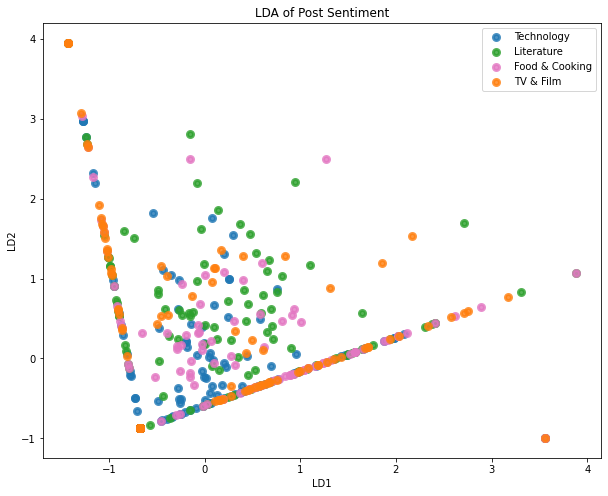

In [ ]:
plt.figure(figsize = (10, 8))
colors = ['tab:blue', 'tab:green', 'tab:pink', 'tab:orange']
lw = 3
for color,target_name in zip(colors, df['label'].unique()):
    plt.scatter(X_text_sent_lda[df['label'] == target_name, 0], X_text_sent_lda[df['label'] == target_name, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title('LDA of Post Sentiment')
plt.show()

#### Linear Discriminant Analysis of the Sentiment of the Post Reply text

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_reply_sent_lda = lda.fit_transform(df[['last_replies_neg', 'last_replies_neu', 'last_replies_pos']], y)

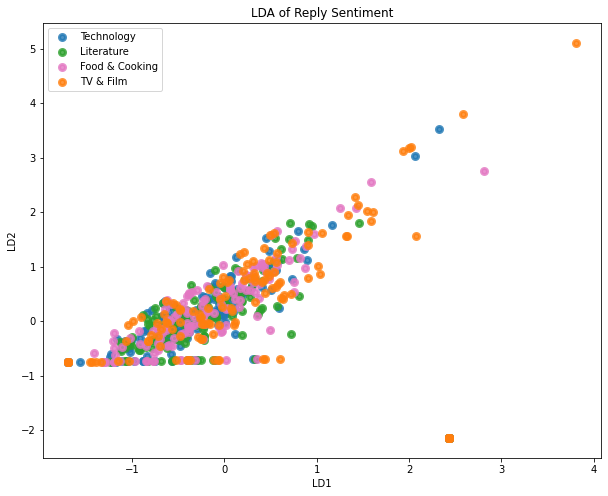

In [ ]:
plt.figure(figsize = (10, 8))
colors = ['tab:blue', 'tab:green', 'tab:pink', 'tab:orange']
lw = 3
for color,target_name in zip(colors, df['label'].unique()):
    plt.scatter(X_reply_sent_lda[df['label'] == target_name, 0], X_reply_sent_lda[df['label'] == target_name, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title('LDA of Reply Sentiment')
plt.show()

#### Linear Discriminant Analysis of the Sentiment of a combination of Post and Reply text

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_all_sent_lda = lda.fit_transform(df[['text_neg', 'text_neu', 'text_pos', 'last_replies_neg', 'last_replies_neu', 'last_replies_pos']], y)

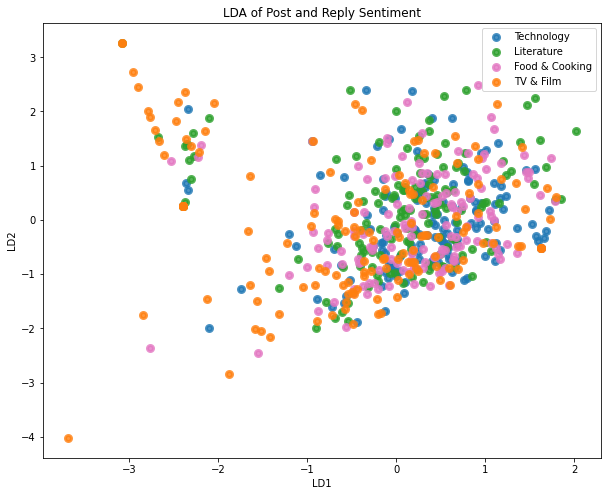

In [ ]:
plt.figure(figsize = (10, 8))
colors = ['tab:blue', 'tab:green', 'tab:pink', 'tab:orange']
lw = 3
for color,target_name in zip(colors, df['label'].unique()):
    plt.scatter(X_all_sent_lda[df['label'] == target_name, 0], X_all_sent_lda[df['label'] == target_name, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title('LDA of Post and Reply Sentiment')
plt.show()

From these graphs we can obeserve that the LDA for Reply and Post text and Reply had the most seperable boundries. Only Post text and the sentiments didn't lead to good seperation of the channels using LDA.

### Principal Component Analysis
In this section explores the use of Principal Component Analysis to seperate the data for different channels and looks at which field seprates it the best.

#### Principal Component Analysis of Post text

In [ ]:
pca = PCA(n_components=2)
X_text_pca = pca.fit_transform(X_text, y)

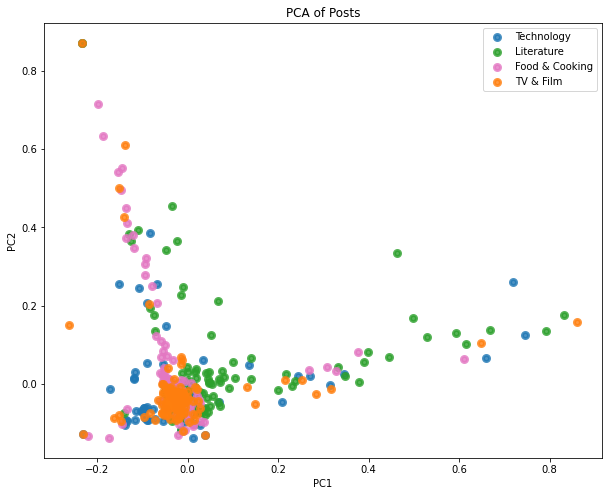

In [ ]:
plt.figure(figsize = (10, 8))
colors = ['tab:blue', 'tab:green', 'tab:pink', 'tab:orange']
lw = 3
for color,target_name in zip(colors, df['label'].unique()):
    plt.scatter(X_text_pca[df['label'] == target_name, 0], X_text_pca[df['label'] == target_name, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PCA of Posts')
plt.show()

#### Principal Component Analysis of Post Reply text

In [ ]:
pca = PCA(n_components=2)
X_reply_pca = pca.fit_transform(X_reply, y)

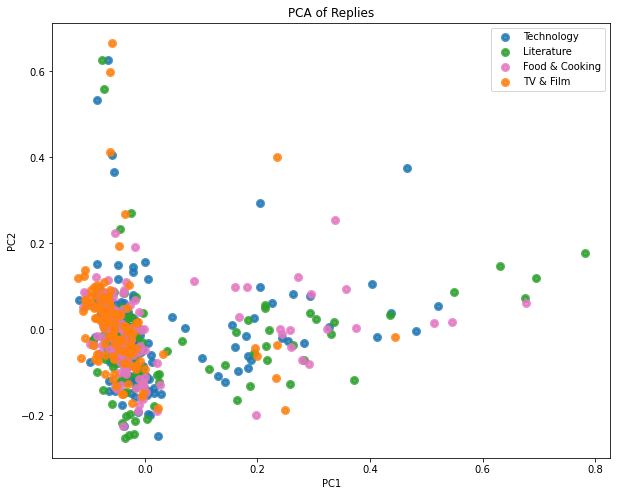

In [ ]:
plt.figure(figsize = (10, 8))
colors = ['tab:blue', 'tab:green', 'tab:pink', 'tab:orange']
lw = 3
for color,target_name in zip(colors, df['label'].unique()):
    plt.scatter(X_reply_pca[df['label'] == target_name, 0], X_reply_pca[df['label'] == target_name, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PCA of Replies')
plt.show()

#### Principal Component Analysis of a combination of Post and Reply text

In [ ]:
pca = PCA(n_components=2)
X_all_text_pca = pca.fit_transform(X_all_text, y)

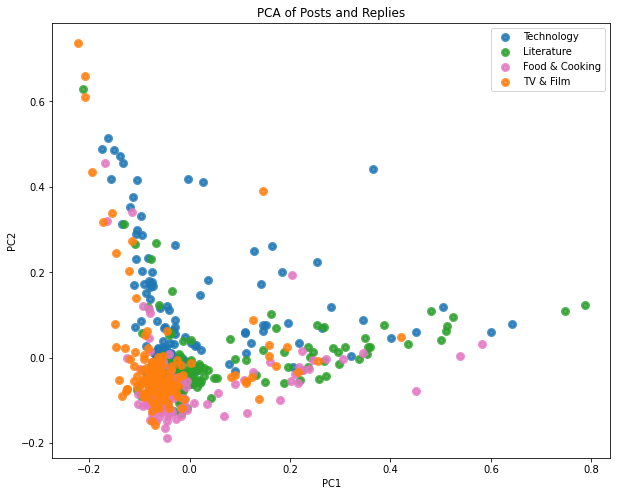

In [ ]:
plt.figure(figsize = (10, 8))
colors = ['tab:blue', 'tab:green', 'tab:pink', 'tab:orange']
lw = 3
for color,target_name in zip(colors, df['label'].unique()):
    plt.scatter(X_all_text_pca[df['label'] == target_name, 0], X_all_text_pca[df['label'] == target_name, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PCA of Posts and Replies')
plt.show()

#### Principal Component Analysis of the Sentiment of the Post text

In [ ]:
pca = PCA(n_components=2)
X_text_sent_pca = pca.fit_transform(df[['text_neg', 'text_neu', 'text_pos']], y)

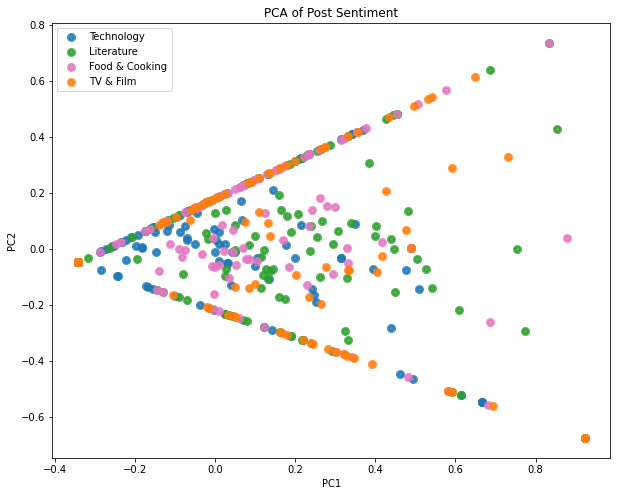

In [ ]:
plt.figure(figsize = (10, 8))
colors = ['tab:blue', 'tab:green', 'tab:pink', 'tab:orange']
lw = 3
for color,target_name in zip(colors, df['label'].unique()):
    plt.scatter(X_text_sent_pca[df['label'] == target_name, 0], X_text_sent_pca[df['label'] == target_name, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PCA of Post Sentiment')
plt.show()

#### Principal Component Analysis of the Sentiment of the Post Reply text

In [ ]:
pca = PCA(n_components=2)
X_reply_sent_pca = pca.fit_transform(df[['last_replies_neg', 'last_replies_neu', 'last_replies_pos']], y)

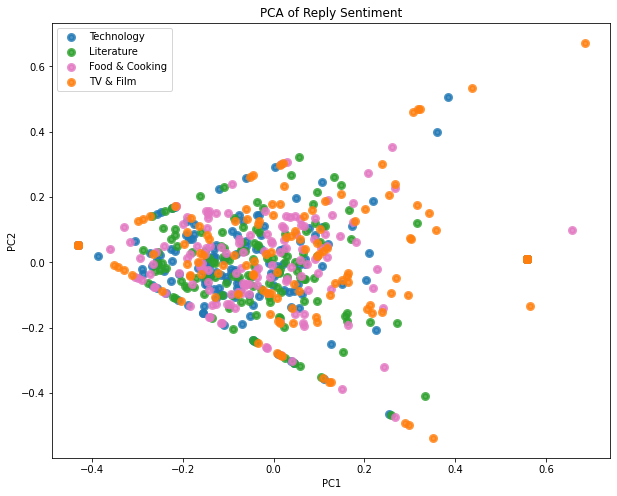

In [ ]:
plt.figure(figsize = (10, 8))
colors = ['tab:blue', 'tab:green', 'tab:pink', 'tab:orange']
lw = 3
for color,target_name in zip(colors, df['label'].unique()):
    plt.scatter(X_reply_sent_pca[df['label'] == target_name, 0], X_reply_sent_pca[df['label'] == target_name, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PCA of Reply Sentiment')
plt.show()

#### Principal Component Analysis of the Sentiment of a combination of Post and Reply text

In [ ]:
pca = PCA(n_components=2)
X_all_sent_pca = pca.fit_transform(df[['text_neg', 'text_neu', 'text_pos', 'last_replies_neg', 'last_replies_neu', 'last_replies_pos']], y)

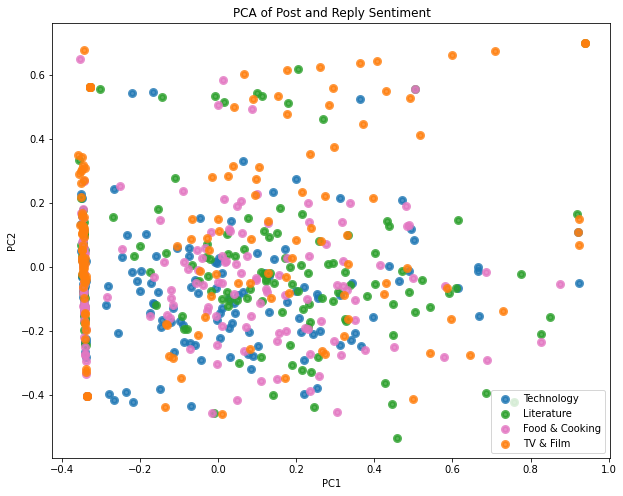

In [ ]:
plt.figure(figsize = (10, 8))
colors = ['tab:blue', 'tab:green', 'tab:pink', 'tab:orange']
lw = 3
for color,target_name in zip(colors, df['label'].unique()):
    plt.scatter(X_all_sent_pca[df['label'] == target_name, 0], X_all_sent_pca[df['label'] == target_name, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PCA of Post and Reply Sentiment')
plt.show()

From these grahps we can conculed that using PCA does not sperate the channels well for any for any of the varaiable in the data.

### Number of replies
In this section we explore if the channels can be differentiated by the number of number of replies for posts

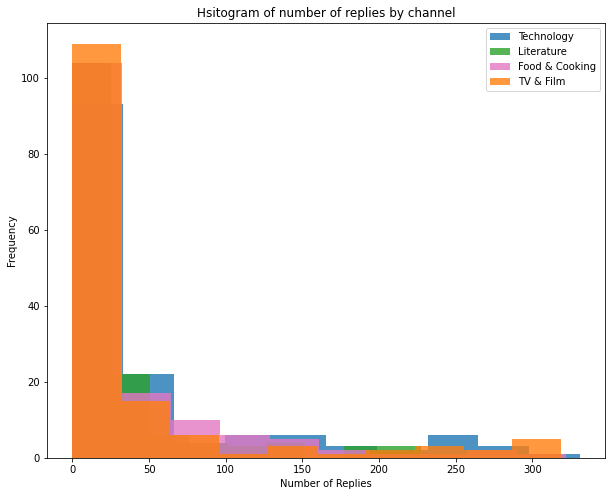

In [ ]:
plt.figure(figsize = (10, 8))
colors = ['tab:blue', 'tab:green', 'tab:pink', 'tab:orange']
lw = 3
for color,target_name in zip(colors, df['label'].unique()):
    plt.hist(df[df['label'] == target_name]['num_replies'], color=color, alpha=.8, lw=lw, 
             label=target_name, histtype = 'barstacked')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("Number of Replies")
plt.ylabel("Frequency")
plt.title('Hsitogram of number of replies by channel')
plt.show()

We can obeserve from the graph that the number of replies is not a good variable to use to seperate the channels.

# Modeling

## Logistic Regression
In this section we will explore modeling the data to predict the channel using Logistic Regression.

### Using only Post text to predict channels

In [ ]:
tfidf = TfidfVectorizer(max_features = 500)
X_text = tfidf.fit_transform(df['text']).toarray()

y_encoder = LabelEncoder()
y = y_encoder.fit_transform(df['label'])

X_reply = tfidf.fit_transform(df['last_replies']).toarray()

X_all_text = tfidf.fit_transform(df['text'] +' ' + df['last_replies']).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_text, y, random_state = 0, test_size = 0.2)

In [ ]:
%%time
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

CPU times: user 120 ms, sys: 52.5 ms, total: 172 ms
Wall time: 99.8 ms


In [ ]:
model.score(X_test, y_test)

0.6386554621848739

### Using only Reply text to predict channels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reply, y, test_size = 0.2, random_state = 0)

In [ ]:
%%time
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

CPU times: user 125 ms, sys: 44.4 ms, total: 169 ms
Wall time: 104 ms


In [ ]:
model.score(X_test, y_test)

0.5966386554621849

### Using both Post text and Reply text to predict channel

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_all_text, y, random_state = 0, test_size = 0.2)

In [ ]:
%%time
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

CPU times: user 93.7 ms, sys: 51.5 ms, total: 145 ms
Wall time: 82.2 ms


In [ ]:
model.score(X_test, y_test)

0.7142857142857143

### Using all the variables to predict channel

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.concatenate((X_all_text, df.drop(columns = ['label', 'text', 'last_replies', 'time']).values), axis = 1), 
                                                    y, random_state = 0)

In [ ]:
%%time
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

CPU times: user 268 ms, sys: 137 ms, total: 405 ms
Wall time: 228 ms


In [ ]:
model.score(X_test, y_test)

0.6621621621621622

### Using both Post text and Reply text to predict channel with Linear Discriminant Analysis

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_all_text, y, random_state = 0, test_size = 0.2)

In [ ]:
%%time
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_train, y_train)

CPU times: user 241 ms, sys: 118 ms, total: 359 ms
Wall time: 193 ms


In [ ]:
%%time
model = LogisticRegression(n_jobs=-1)
model.fit(lda.transform(X_train), y_train)

CPU times: user 23.8 ms, sys: 52.4 ms, total: 76.3 ms
Wall time: 1.02 s


In [ ]:
model.score(lda.transform(X_test), y_test)

0.3445378151260504

#### Optimizing the hyperparameters

In [ ]:
def lr_score(params):
    lda = LinearDiscriminantAnalysis(n_components=params['n_components'])
    lda.fit(X_train, y_train)
    del params['n_components']
    model = LogisticRegression(**params)
    model.fit(lda.transform(X_train), y_train)
    acc = model.score(lda.transform(X_test), y_test)
   #acc = np.mean(cross_validate(LogisticRegression(**params), lda.transform(X_train), y_train, cv = 5)['test_score'])
    return {'loss': -1 * acc, 'status': STATUS_OK}

In [ ]:
def lr_optimize(evals, trials, optimizer=tpe.suggest, random_state=0):
    space = {
        'n_components': hp.choice('n_components', np.arange(2, 300, dtype=int)),
        'C': hp.choice('C', [0.001,0.01,0.1,1,10,100]),
        'random_state': 0
    }
    best = fmin(lr_score, space, algo=tpe.suggest, max_evals=evals, trials = trials, rstate =  np.random.RandomState(0))
    return best

In [ ]:
%%time
trials = Trials()
n= 500
lr_best_params = lr_optimize(evals = n,
                      optimizer=tpe.suggest,
                      trials = trials)

100%|██████████| 500/500 [02:11<00:00,  3.81it/s, best loss: -0.46218487394957986]
CPU times: user 2min 47s, sys: 1min 14s, total: 4min 1s
Wall time: 2min 11s


In [ ]:
lr_best_params

{'C': 4, 'n_components': 59}

In [ ]:
%%time
lda = LinearDiscriminantAnalysis(n_components=lr_best_params['n_components'])
lda.fit(X_train, y_train)

CPU times: user 234 ms, sys: 89.1 ms, total: 323 ms
Wall time: 177 ms


In [ ]:
%%time
model = LogisticRegression(C=lr_best_params['C'], random_state=0)
model.fit(lda.transform(X_train), y_train)

CPU times: user 33.5 ms, sys: 23.4 ms, total: 56.9 ms
Wall time: 33.5 ms


In [ ]:
model.score(lda.transform(X_test), y_test)

0.42857142857142855

### Using both Post text and Reply text to predict channel with Principal component analysis

In [ ]:
pca = PCA(n_components=3)
pca.fit(X_train, y_train)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
%%time
model = LogisticRegression(n_jobs=-1)
model.fit(pca.transform(X_train), y_train)

CPU times: user 23.9 ms, sys: 90.6 ms, total: 115 ms
Wall time: 393 ms


In [ ]:
model.score(pca.transform(X_test), y_test)

0.5378151260504201

#### Optimizing the hyperparameters

In [ ]:
def lr_score(params):
    pca = PCA(n_components=params['n_components'])
    pca.fit(X_train, y_train)
    del params['n_components']
    model = LogisticRegression(**params)
    model.fit(pca.transform(X_train), y_train)
    acc = model.score(pca.transform(X_test), y_test)
   #acc = np.mean(cross_validate(LogisticRegression(**params), lda.transform(X_train), y_train, cv = 5)['test_score'])
    return {'loss': -1 * acc, 'status': STATUS_OK}

In [ ]:
def lr_optimize(evals, trials, optimizer=tpe.suggest, random_state=0):
    space = {
        'n_components': hp.choice('n_components', np.arange(2, 300, dtype=int)),
        'C': hp.choice('C', [0.001,0.01,0.1,1,10,100]),
        'random_state': 0
    }
    best = fmin(lr_score, space, algo=tpe.suggest, max_evals=evals, trials = trials, rstate =  np.random.RandomState(0))
    return best

In [ ]:
%%time
trials = Trials()
n= 500
lr_best_params = lr_optimize(evals = n,
                      optimizer=tpe.suggest,
                      trials = trials)

100%|██████████| 500/500 [02:08<00:00,  3.90it/s, best loss: -0.773109243697479]
CPU times: user 2min 48s, sys: 1min 14s, total: 4min 2s
Wall time: 2min 8s


In [ ]:
lr_best_params

{'C': 4, 'n_components': 24}

In [ ]:
pca = PCA(n_components=lr_best_params['n_components'])
pca.fit(X_train, y_train)

PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
model = LogisticRegression(C = lr_best_params['C'], n_jobs=-1)
model.fit(pca.transform(X_train), y_train)

LogisticRegression(C=4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model.score(pca.transform(X_test), y_test)

0.7647058823529411

## Deep Neural Network
In this section we will explore modeling the data to predict the channel using Deep Neural Networks. I had used Glove embedding insteading training my own due to the limited umber of records available.

In [ ]:
X = df['text'] + ' ' + df['last_replies']
y = pd.get_dummies(df['label'])

In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

length = max([len(s.split()) for s in df['text']])
vocab_size = len(tokenizer.word_index) + 1

X = pad_sequences(X, maxlen=length, padding='post')

In [ ]:
num_classes = y.shape[1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
# using glove vector to create function that makes word emebeddings
def load_glove_vectors():
    embeddings_index = {}
    with open('/content/drive/My Drive/NLP/glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [ ]:
def define_model(aplha):
    
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=length, trainable=False, weights=[embedding_matrix]))
    
    model.add(Conv1D(filters=64, kernel_size=10, padding='same', activation = 'relu', input_shape=(length,), kernel_regularizer=regularizers.l2(aplha)))
    model.add(MaxPooling1D(pool_size=2))

    
    model.add(Conv1D(filters=num_classes, kernel_size=123, padding='valid', kernel_regularizer=regularizers.l2(aplha)))
    model.add(Reshape((num_classes,)))
    model.add(Activation('softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = define_model(0.0055)
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 246, 100)          926600    
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 246, 64)           64064     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 123, 64)           0         
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 1, 4)              31492     
_________________________________________________________________
reshape_26 (Reshape)         (None, 4)                 0         
_________________________________________________________________
activation_25 (Activation)   (None, 4)                 0         
Total params: 1,022,156
Trainable params: 95,556
Non-trainable params: 926,600
________________________________________

In [ ]:
model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32)

Train on 425 samples, validate on 48 samples
Epoch 1/10
425/425 [==============================] - 1s 3ms/step - loss: 1.7323 - accuracy: 0.3929 - val_loss: 1.5117 - val_accuracy: 0.6042
Epoch 2/10
425/425 [==============================] - 1s 2ms/step - loss: 1.1396 - accuracy: 0.7835 - val_loss: 1.2295 - val_accuracy: 0.7292
Epoch 3/10
425/425 [==============================] - 1s 2ms/step - loss: 0.8571 - accuracy: 0.8682 - val_loss: 1.1098 - val_accuracy: 0.7292
Epoch 4/10
425/425 [==============================] - 1s 2ms/step - loss: 0.6978 - accuracy: 0.9176 - val_loss: 0.9625 - val_accuracy: 0.8125
Epoch 5/10
425/425 [==============================] - 1s 2ms/step - loss: 0.6037 - accuracy: 0.9529 - val_loss: 0.8980 - val_accuracy: 0.8125
Epoch 6/10
425/425 [==============================] - 1s 2ms/step - loss: 0.5388 - accuracy: 0.9671 - val_loss: 0.8482 - val_accuracy: 0.8125
Epoch 7/10
425/425 [==============================] - 1s 2ms/step - loss: 0.4802 - accuracy: 0.9765 - v

In [ ]:
model.evaluate(X_test, y_test)

119/119 [==============================] - 0s 782us/step


[0.8187826691555375, 0.7731092572212219]